<a href="https://colab.research.google.com/github/DhrubaAdhikary/eagleview/blob/main/Digital%20Twin%20for%20Temp%20Sensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MIMO Digital Twin

<p class='vspace'>This is a hands-on application of machine learning and advanced temperature control with two heaters and two temperature sensors. This reinforce principles of model development, estimation, and advanced control methods. 
</p>
</div><h4>Data and Solutions</h4>

<div class='vspace'></div><ul><li><a class='urllink' href='https://apmonitor.com/pdc/index.php/Main/ArduinoModeling2' rel='nofollow'>MIMO Energy Balance Solution with MATLAB and Python</a>
</li><li><a class='urllink' href='http://apmonitor.com/do/uploads/Main/tclab_ss_data2.txt' rel='nofollow'>Steady state data, 2 heaters</a>
</li><li><a class='urllink' href='http://apmonitor.com/do/uploads/Main/tclab_dyn_data2.txt' rel='nofollow'>Dynamic data, 2 heaters</a>

     |████████████████████████████████| 90 kB 6.4 MB/s 
TCLab version 0.4.9
Simulated TCLab
Time: 0 H1: 0.0 H2: 0.0 T1: 20.949499999999997 T2: 20.949499999999997
Time: 1 H1: 0.0 H2: 0.0 T1: 20.949499999999997 T2: 20.949499999999997
Time: 2 H1: 0.0 H2: 0.0 T1: 20.949499999999997 T2: 20.949499999999997
Time: 3 H1: 0.0 H2: 0.0 T1: 20.949499999999997 T2: 20.949499999999997
Time: 4 H1: 0.0 H2: 0.0 T1: 20.6272 T2: 20.949499999999997
Time: 5 H1: 0.0 H2: 0.0 T1: 20.949499999999997 T2: 20.949499999999997
Time: 6 H1: 0.0 H2: 0.0 T1: 20.949499999999997 T2: 20.949499999999997
Time: 7 H1: 0.0 H2: 0.0 T1: 20.949499999999997 T2: 20.949499999999997
Time: 8 H1: 0.0 H2: 0.0 T1: 20.949499999999997 T2: 20.949499999999997
Time: 9 H1: 0.0 H2: 0.0 T1: 20.949499999999997 T2: 20.949499999999997
Time: 10 H1: 80.0 H2: 0.0 T1: 20.949499999999997 T2: 20.949499999999997
Time: 11 H1: 80.0 H2: 0.0 T1: 20.949499999999997 T2: 20.949499999999997
Time: 12 H1: 80.0 H2: 0.0 T1: 21.594099999999997 T2: 20.949499999999997
Tim

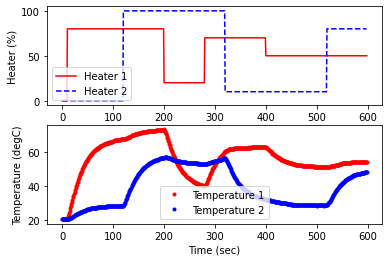

In [3]:
#@title  Python Generate Step Data

!pip install tclab

import numpy as np
import pandas as pd
import tclab
import time
import matplotlib.pyplot as plt

# generate step test data on Arduino
filename = 'tclab_dyn_data2.csv'

# heater steps
Q1d = np.zeros(601)
Q1d[10:200] = 80
Q1d[200:280] = 20
Q1d[280:400] = 70
Q1d[400:] = 50

Q2d = np.zeros(601)
Q2d[120:320] = 100
Q2d[320:520] = 10
Q2d[520:] = 80

#Set connected=True to connect with Arduino Hardware
#Set connected=False to connect to virtual TCLab
TCLab = tclab.setup(connected=False, speedup=5)


# Connect to Arduino
a = TCLab()
fid = open(filename,'w')
fid.write('Time,H1,H2,T1,T2\n')
fid.close()

# run step test (10 min)
for i in range(601):
    # set heater values
    a.Q1(Q1d[i])
    a.Q2(Q2d[i])
    print('Time: ' + str(i) + \
          ' H1: ' + str(Q1d[i]) + \
          ' H2: ' + str(Q2d[i]) + \
          ' T1: ' + str(a.T1)   + \
          ' T2: ' + str(a.T2))
    # wait 1 second
    time.sleep(1)
    fid = open(filename,'a')
    fid.write(str(i)+','+str(Q1d[i])+','+str(Q2d[i])+',' \
              +str(a.T1)+','+str(a.T2)+'\n')
# close connection to Arduino
a.close()

# read data file
data = pd.read_csv(filename)

# plot measurements
plt.figure()
plt.subplot(2,1,1)
plt.plot(data['Time'],data['H1'],'r-',label='Heater 1')
plt.plot(data['Time'],data['H2'],'b--',label='Heater 2')
plt.ylabel('Heater (%)')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(data['Time'],data['T1'],'r.',label='Temperature 1')
plt.plot(data['Time'],data['T2'],'b.',label='Temperature 2')
plt.ylabel('Temperature (degC)')
plt.legend(loc='best')
plt.xlabel('Time (sec)')
plt.savefig('tclab_dyn_meas2.png')

plt.show()

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


apm 35.230.124.223_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            1
   Variables    :           16
   Intermediates:            2
   Connections  :            0
   Equations    :            4
   Residuals    :            2
 
 Number of state variables:           2400
 Number of total equations: -         2400
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 **********************************************
 Dynamic Simulation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains 

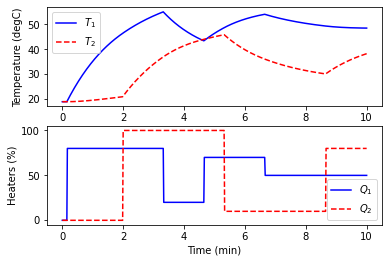

In [4]:
#@title Python GEKKO Energy Balance
try:
    from pip import main as pipmain
except:
    from pip._internal import main as pipmain
pipmain(['install','gekko'])

import numpy as np
import matplotlib.pyplot as plt
from gekko import GEKKO

#initialize GEKKO model
m = GEKKO()

#model discretized time
n = 60*10+1  # Number of second time points (10min)
m.time = np.linspace(0,n-1,n) # Time vector

# Parameters
# Percent Heater (0-100%)
Q1d = np.zeros(n)
Q1d[10:200] = 80
Q1d[200:280] = 20
Q1d[280:400] = 70
Q1d[400:] = 50
Q1 = m.Param()
Q1.value = Q1d

Q2d = np.zeros(n)
Q2d[120:320] = 100
Q2d[320:520] = 10
Q2d[520:] = 80
Q2 = m.Param()
Q2.value = Q2d# Heaters as time-varying inputs
Q1 = m.Param(value=Q1d) # Percent Heater (0-100%)
Q2 = m.Param(value=Q2d) # Percent Heater (0-100%)

T0 = m.Param(value=19.0+273.15)     # Initial temperature
Ta = m.Param(value=19.0+273.15)     # K
U =  m.Param(value=10.0)            # W/m^2-K
mass = m.Param(value=4.0/1000.0)    # kg
Cp = m.Param(value=0.5*1000.0)      # J/kg-K    
A = m.Param(value=10.0/100.0**2)    # Area not between heaters in m^2
As = m.Param(value=2.0/100.0**2)    # Area between heaters in m^2
alpha1 = m.Param(value=0.01)        # W / % heater
alpha2 = m.Param(value=0.005)      # W / % heater
eps = m.Param(value=0.9)            # Emissivity
sigma = m.Const(5.67e-8)            # Stefan-Boltzman

# Temperature states as GEKKO variables
T1 = m.Var(value=T0)
T2 = m.Var(value=T0)         

# Between two heaters
Q_C12 = m.Intermediate(U*As*(T2-T1)) # Convective
Q_R12 = m.Intermediate(eps*sigma*As*(T2**4-T1**4)) # Radiative

m.Equation(T1.dt() == (1.0/(mass*Cp))*(U*A*(Ta-T1) \
                    + eps * sigma * A * (Ta**4 - T1**4) \
                    + Q_C12 + Q_R12 \
                    + alpha1*Q1))

m.Equation(T2.dt() == (1.0/(mass*Cp))*(U*A*(Ta-T2) \
                    + eps * sigma * A * (Ta**4 - T2**4) \
                    - Q_C12 - Q_R12 \
                    + alpha2*Q2))

#simulation mode
m.options.IMODE = 4

#simulation model
m.solve()

#plot results
plt.figure(1)
plt.subplot(2,1,1)
plt.plot(m.time/60.0,np.array(T1.value)-273.15,'b-')
plt.plot(m.time/60.0,np.array(T2.value)-273.15,'r--')
plt.legend([r'$T_1$',r'$T_2$'],loc='best')
plt.ylabel('Temperature (degC)')

plt.subplot(2,1,2)
plt.plot(m.time/60.0,np.array(Q1.value),'b-')
plt.plot(m.time/60.0,np.array(Q2.value),'r--')
plt.legend([r'$Q_1$',r'$Q_2$'],loc='best')
plt.ylabel('Heaters (%)')

plt.xlabel('Time (min)')
plt.show()

apm 35.230.124.223_gk_model1 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :           28
   Intermediates:           12
   Connections  :            0
   Equations    :           14
   Residuals    :            2
 
 Number of state variables:            264
 Number of total equations: -          240
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :             24
 
 ----------------------------------------------
 Model Parameter Estimation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  6.63054E+01  2.99055E+00
    1  5.12142E+01  5.67449E-01
    2  7.87133E+01  3.68091E-01


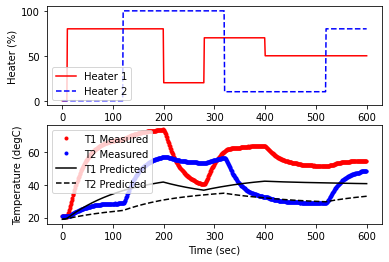

In [5]:
#@title Python GEKKO Neural Network

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from gekko import GEKKO

import time

# -------------------------------------
# import or generate data
# -------------------------------------
filename = 'tclab_ss_data2.csv'
try:
    try:
        data = pd.read_csv(filename)
    except:
        url = 'https://apmonitor.com/do/uploads/Main/tclab_ss_data2.txt'
        data = pd.read_csv(url)
except:
    # generate training data if data file not available
    import tclab
    
    #Set connected=True to connect with Arduino Hardware
    #Set connected=False to connect to virtual TCLab
    TCLab = tclab.setup(connected=False, speedup=5)

    # Connect to Arduino
    a = TCLab()
    fid = open(filename,'w')
    fid.write('Heater 1,Heater 2,Temperature 1,Temperature 2\n')
    fid.close()
    # data collection takes 6 hours = 120 pts * 3 minutes each
    npts = 120
    for i in range(npts):
        # set random heater values
        Q1 = np.random.rand()*100
        Q2 = np.random.rand()*100
        a.Q1(Q1)
        a.Q2(Q2)
        print('Heater 1: ' + str(Q1) + ' %')
        print('Heater 2: ' + str(Q2) + ' %')
        # wait 3 minutes
        time.sleep(3*60)
        # record temperature and heater value
        print('Temperature 1: ' + str(a.T1) + ' degC')
        print('Temperature 2: ' + str(a.T2) + ' degC')
        fid = open(filename,'a')
        fid.write(str(Q1)+','+str(Q2)+','+str(a.T1)+','+str(a.T2)+'\n')
        fid.close()
    # close connection to Arduino
    a.close()
    # read data file
    data = pd.read_csv(filename)

# -------------------------------------
# scale data
# -------------------------------------
s = MinMaxScaler(feature_range=(0,1))
sc_train = s.fit_transform(data)

# partition into inputs and outputs
xs = sc_train[:,0:2] # 2 heaters
ys = sc_train[:,2:4] # 2 temperatures

# -------------------------------------
# build neural network
# -------------------------------------
nin = 2  # inputs
n1 = 2   # hidden layer 1 (linear)
n2 = 2   # hidden layer 2 (nonlinear)
n3 = 2   # hidden layer 3 (linear)
nout = 2 # outputs

# Initialize gekko models
train = GEKKO() 
dyn   = GEKKO()
model = [train,dyn]

for m in model:
    # use APOPT solver
    m.options.SOLVER = 1

    # input(s)
    m.inpt = [m.Param() for i in range(nin)]

    # layer 1 (linear)
    m.w1 = m.Array(m.FV, (nout,nin,n1))
    m.l1 = [[m.Intermediate(sum([m.w1[k,j,i]*m.inpt[j] \
            for j in range(nin)])) for i in range(n1)] \
            for k in range(nout)]

    # layer 2 (tanh)
    m.w2 = m.Array(m.FV, (nout,n1,n2))
    m.l2 = [[m.Intermediate(sum([m.tanh(m.w2[k,j,i]*m.l1[k][j]) \
            for j in range(n1)])) for i in range(n2)] \
            for k in range(nout)]

    # layer 3 (linear)
    m.w3 = m.Array(m.FV, (nout,n2,n3))
    m.l3 = [[m.Intermediate(sum([m.w3[k,j,i]*m.l2[k][j] \
            for j in range(n2)])) for i in range(n3)] \
            for k in range(nout)]

    # outputs
    m.outpt = [m.CV() for i in range(nout)]
    m.Equations([m.outpt[k]==sum([m.l3[k][i] for i in range(n3)]) \
                 for k in range(nout)])

    # flatten matrices
    m.w1 = m.w1.flatten()
    m.w2 = m.w2.flatten()
    m.w3 = m.w3.flatten()

# -------------------------------------
# fit parameter weights
# -------------------------------------
m = train
for i in range(nin):
    m.inpt[i].value=xs[:,i]
for i in range(nout):
    m.outpt[i].value = ys[:,i]
    m.outpt[i].FSTATUS = 1
for i in range(len(m.w1)):
    m.w1[i].FSTATUS=1
    m.w1[i].STATUS=1
    m.w1[i].MEAS=1.0
for i in range(len(m.w2)):
    m.w2[i].STATUS=1
    m.w2[i].FSTATUS=1
    m.w2[i].MEAS=0.5
for i in range(len(m.w3)):
    m.w3[i].FSTATUS=1
    m.w3[i].STATUS=1
    m.w3[i].MEAS=1.0
m.options.IMODE = 2
m.options.EV_TYPE = 2

# solve for weights to minimize loss (objective)
m.solve(disp=True)

# -------------------------------------
# generate dynamic predictions
# -------------------------------------
m = dyn
tf = 600
m.time = np.linspace(0,tf,tf+1)
# load neural network parameters
for i in range(len(m.w1)):
    m.w1[i].MEAS=train.w1[i].NEWVAL
    m.w1[i].FSTATUS = 1
for i in range(len(m.w2)):
    m.w2[i].MEAS=train.w2[i].NEWVAL
    m.w2[i].FSTATUS = 1
for i in range(len(m.w3)):
    m.w3[i].MEAS=train.w3[i].NEWVAL
    m.w3[i].FSTATUS = 1
# step tests
Q1d = np.zeros(tf+1)
Q1d[10:200] = 80
Q1d[200:280] = 20
Q1d[280:400] = 70
Q1d[400:] = 50
Q1 = m.Param()
Q1.value = Q1d

Q2d = np.zeros(tf+1)
Q2d[120:320] = 100
Q2d[320:520] = 10
Q2d[520:] = 80
Q2 = m.Param()
Q2.value = Q2d

# scaled inputs
m.inpt[0].value = Q1d * s.scale_[0] + s.min_[0]
m.inpt[1].value = Q2d * s.scale_[1] + s.min_[1] 

# define Temperature output
Q0 = 0   # initial heater
T0 = 19  # ambient temperature
# scaled steady state ouput
T1_ss = m.Var(value=T0)
T2_ss = m.Var(value=T0)
m.Equation(T1_ss == (m.outpt[0]-s.min_[2])/s.scale_[2])
m.Equation(T2_ss == (m.outpt[1]-s.min_[3])/s.scale_[3])
# dynamic prediction
T1 = m.Var(value=T0)
T2 = m.Var(value=T0)
# time constant
tau = m.Param(value=120) # determine in a later exercise
# additional model equation for dynamics
m.Equation(tau*T1.dt()==-(T1-T0)+(T1_ss-T0))
m.Equation(tau*T2.dt()==-(T2-T0)+(T2_ss-T0))

# solve dynamic simulation
m.options.IMODE=4
m.solve()

# generate step test data on Arduino
# -------------------------------------
# import or generate data
# -------------------------------------
filename = 'tclab_dyn_data2.csv'
try:
    try:
        data = pd.read_csv(filename)
    except:
        url = 'https://apmonitor.com/do/uploads/Main/tclab_dyn_data2.txt'
        data = pd.read_csv(url)
except:
    # generate training data if data file not available
    import tclab
    # Connect to Arduino
    a = tclab.TCLab()
    fid = open(filename,'w')
    fid.write('Time,H1,H2,T1,T2\n')
    fid.close()
    # check for cool down
    i = 0
    while i<=10:
        i += 1 # upper limit on wait time
        T1m = a.T1
        T2m = a.T2
        print('T1: ' + str(a.T1) + ' T2: ' + str(a.T2))
        print('Sleep 30 sec')
        time.sleep(30)
        if (a.T1<30 and a.T2<30 and a.T1>=T1m-0.2 and a.T2>=T2m-0.2):
            break  # continue when conditions met
        else:
            print('Not at ambient temperature')
    # run step test (10 min)
    for i in range(tf+1):
        # set heater values
        a.Q1(Q1d[i])
        a.Q2(Q2d[i])
        print('Time: ' + str(i) + \
              ' H1: ' + str(Q1d[i]) + \
              ' H2: ' + str(Q2d[i]) + \
              ' T1: ' + str(a.T1)   + \
              ' T2: ' + str(a.T2))
        # wait 1 second
        time.sleep(1)
        fid = open(filename,'a')
        fid.write(str(i)+','+str(Q1d[i])+','+str(Q2d[i])+',' \
                  +str(a.T1)+','+str(a.T2)+'\n')
        fid.close()
    # close connection to Arduino
    a.close()
    # read data file
    data = pd.read_csv(filename)

# plot prediction and measurement
plt.figure()
plt.subplot(2,1,1)
plt.plot(m.time,Q1.value,'r-',label='Heater 1')
plt.plot(m.time,Q2.value,'b--',label='Heater 2')
plt.ylabel('Heater (%)')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(data['Time'],data['T1'],'r.',label='T1 Measured')
plt.plot(data['Time'],data['T2'],'b.',label='T2 Measured')
plt.plot(m.time,T1.value,'k-',label='T1 Predicted')
plt.plot(m.time,T2.value,'k--',label='T2 Predicted')
plt.ylabel('Temperature (degC)')
plt.legend(loc='best')
plt.xlabel('Time (sec)')
plt.savefig('tclab_dyn_pred.png')

plt.show()